# Discrete vs continuous convolution issues in simulation
----

##### TL;DR: Bloniasz et al. 2025 is built around simulating point processes in continuous time. As such, popular functions in python to complete discrete time convolutions in an elegant way (e.g., numpy.convolve) will lead to a loss of information that leads to inaccuracies both in simulating data than then accurately captures. Thus, we've implemented a (nearly)-continuous-time convolution and have used the shifting property of delta functions in a time invariant and linear system to show that a continuous convolution in this case is effectively a summation of shifted kerenls. 

## Definition of Continuous-Time Convolution

For two continuous-time signals $x(t)$ and $h(t)$, their convolution is defined as:

$$
y(t) = (x * h)(t) = \int_{-\infty}^{\infty} x(\tau)\, h(t - \tau)\, d\tau.
$$


Suppose the input $x(t)$ is a **point process**, i.e., a sum of scaled Dirac delta functions located at times $(t_k)$:

$$
x(t) = \sum_{k} a_k\,\delta(t - t_k),
$$

where each $a_k$ is the amplitude associated with the delta impulse at time $t_k$, here being unit impulses.

---

## Convolution of a Dirac Delta with $h(t)$

Using the **sifting property** of the delta function:

$$
\delta(t - t_k) * h(t) = \int_{-\infty}^{\infty} \delta(\tau - t_k)\, h(t - \tau)\, d\tau = h(t - t_k).
$$

This means convolving a single delta impulse with $h(t)$ simply **shifts** $h(t)$ by $t_k$.


Using the linearity of convolution and the superposition property of deltas, we convolve the entire sum of impulses with $h(t)$:

$$
y(t) = (x * h)(t) = \left(\sum_{k} a_k \delta(t - t_k)\right) * h(t).
$$

By linearity of convolution:

$$
y(t) = \sum_{k} a_k \big[\delta(t - t_k) * h(t)\big] = \sum_{k} a_k\,h(t - t_k).
$$

---

## Summary

The output $y(t)$ of convolving a point process $x(t)$ with a kernel $h(t)$ is:

$$
y(t) = \sum_{k} a_k\,h(t - t_k).
$$

- Each delta impulse in $x(t)$ produces a **shifted copy** of the kernel $h(t)$.
- The overall output is the **sum of all these shifted kernels** (as the analytical answer and not an approximation)


However, we should note that because the final time series is not continous time and is sampled at fs, we are essentially forfeiting the exact solution for a solution that is only as clear as the sampling rate allows.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess
from filtered_point_process.point_processes.filters import Filter

def simulate_and_compare(fs, T, lambda_0, seed=42):
    """
    Simulates a homogeneous Poisson process, applies GABA filter, and compares continuous
    and discrete convolution results.

    Parameters:
        fs (int): Sampling frequency in Hz.
        T (float): Duration of the simulation in seconds.
        lambda_0 (float): Poisson rate (spikes per second).
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (time_axis, continuous_result, discrete_full_time_axis, discrete_result_full, diff_values)
    """
    model_params = {"lambda_0": lambda_0}
    simulation_params = {"fs": fs, "T": T, "simulate": True, "seed": seed}
    model = Model("homogeneous_poisson", model_params, simulation_params)

    filters = {"GABA": "GABA"}
    filter_params = {}

    fpp = FilteredPointProcess(filters=filters, model=model, filter_params=filter_params)
    fpp.apply_filter_sequences(["GABA"])

    kernel = fpp.filter_instances["GABA"].kernel
    kernel_time = fpp.filter_instances["GABA"].kernel_time_axis
    spike_times = model.spikes
    time_axis = fpp.time_axis

    # Continuous convolution
    continuous_result = fpp.continuous_convolution(spike_times, kernel, kernel_time, time_axis)

    # Discrete convolution
    spike_train = np.zeros_like(time_axis)
    for st in spike_times:
        idx = int(round(st * fs))
        if idx < len(spike_train):
            spike_train[idx] = 1

    discrete_result_full = np.convolve(spike_train, kernel, mode="full")
    dt = 1 / fs
    discrete_full_time_axis = np.arange(len(discrete_result_full)) * dt

    # Difference calculation
    idx_end = len(time_axis)
    diff_values = discrete_result_full[:idx_end] - continuous_result

    return time_axis, continuous_result, discrete_full_time_axis, discrete_result_full, diff_values


def plot_results(time_axis, continuous_result, discrete_full_time_axis, discrete_result_full, diff_values, fs, lambda_0):
    """
    Plots the results of continuous and discrete convolution and their difference.

    Parameters:
        time_axis (np.ndarray): Time axis for the continuous result.
        continuous_result (np.ndarray): Continuous convolution result.
        discrete_full_time_axis (np.ndarray): Time axis for the discrete convolution.
        discrete_result_full (np.ndarray): Discrete convolution result.
        diff_values (np.ndarray): Difference between the continuous and discrete results.
        fs (int): Sampling frequency in Hz (for labeling).
        lambda_0 (float): Poisson rate (for labeling).
    """
    plt.figure(figsize=(9, 4))
    plt.plot(time_axis, continuous_result, label="Continuous", color="blue")
    plt.plot(discrete_full_time_axis, discrete_result_full, "--", label="Discrete", color="red")
    plt.xlim(0, time_axis[-1])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Convolution Comparison (fs={fs}, lambda={lambda_0})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 3))
    plt.plot(time_axis, diff_values, color="black")
    plt.xlim(0, time_axis[-1])
    plt.xlabel("Time (s)")
    plt.ylabel("Difference")
    plt.title(f"Difference Between Convolutions (fs={fs}, lambda={lambda_0})")
    plt.tight_layout()
    plt.show()




## Simulate for fs=500 and lambda_0=100

/Users/patrick_bloniasz/filtered-point-process/filtered_point_process/cif/HomogeneousPoisson.py:76: UserWarning: The 'CIF' of a homogeneous process is its constant intensity.As such, the spectrum of the 'CIF' of a Homo. Pois. process andThe spectrum at the level of the point process is identical.
  warnings.warn(


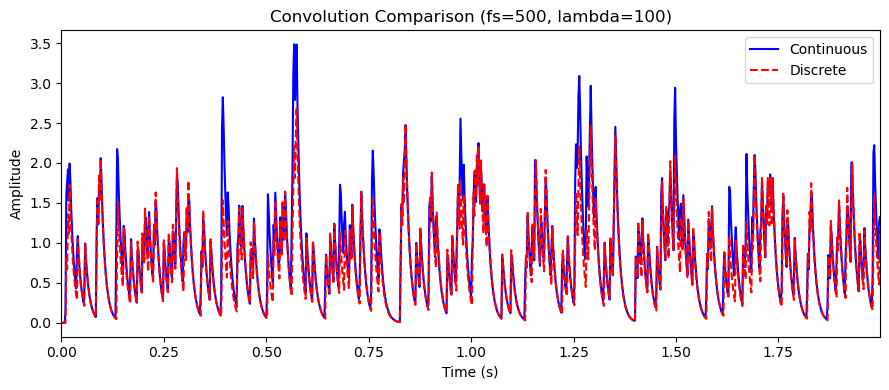

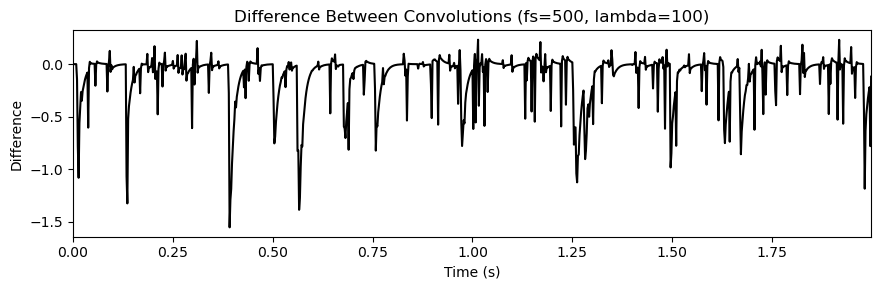

In [2]:
T = 2
seed = 42

fs = 500
lambda_0 = 100

results = simulate_and_compare(fs, T, lambda_0, seed)
plot_results(*results, fs=fs, lambda_0=lambda_0)


## Simulate for fs=500 and lambda_0=500



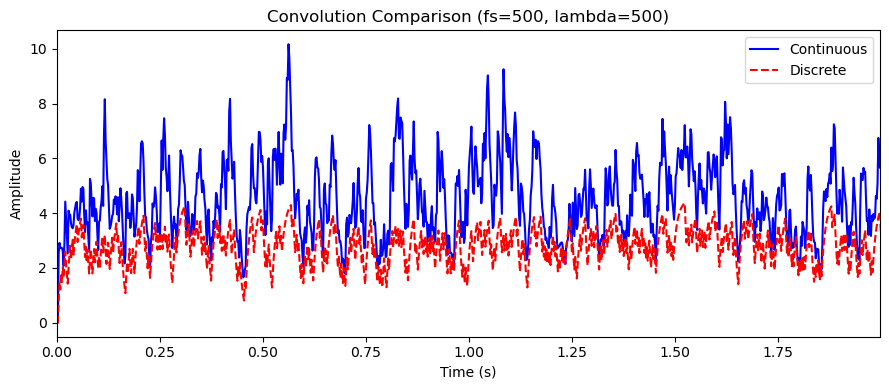

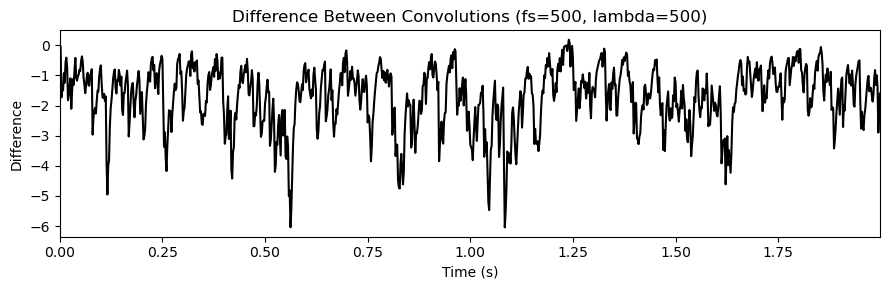

In [3]:
fs = 500
lambda_0 = 500

results = simulate_and_compare(fs, T, lambda_0, seed)
plot_results(*results, fs=fs, lambda_0=lambda_0)


## Simulate for fs=500 and lambda_0=1000

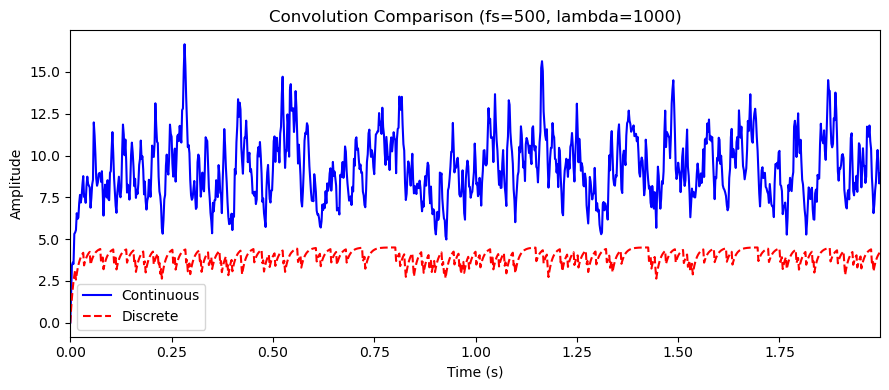

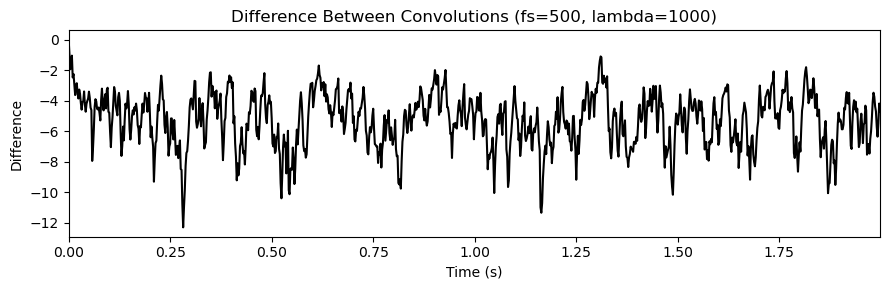

In [4]:
fs = 500
lambda_0 = 1000

results = simulate_and_compare(fs, T, lambda_0, seed)
plot_results(*results, fs=fs, lambda_0=lambda_0)


## Simulate for fs=1000 and lambda_0=100

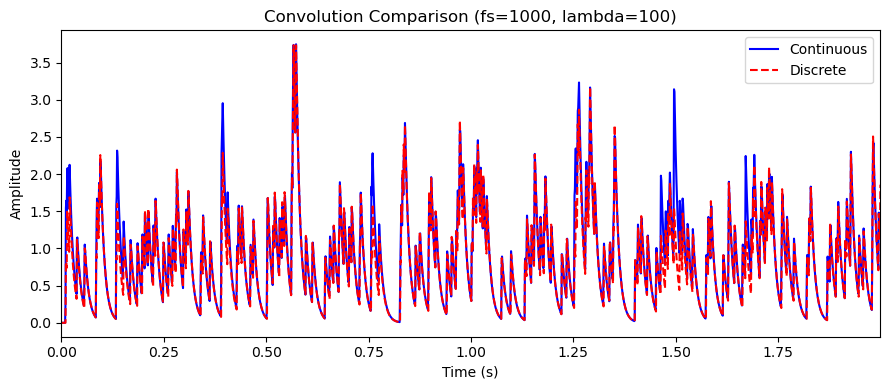

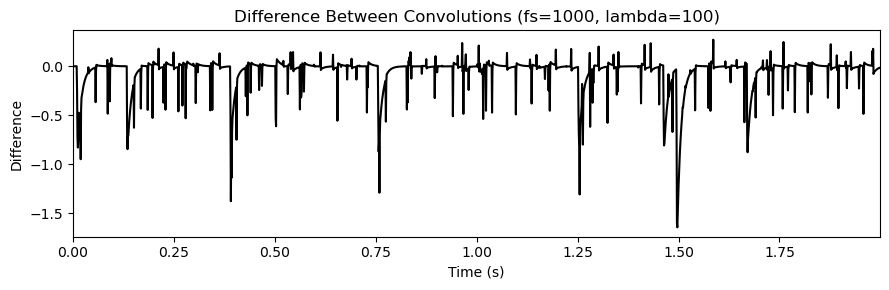

In [5]:
fs = 1000
lambda_0 = 100

results = simulate_and_compare(fs, T, lambda_0, seed)
plot_results(*results, fs=fs, lambda_0=lambda_0)


## Simulate for fs=1000 and lambda_0=500

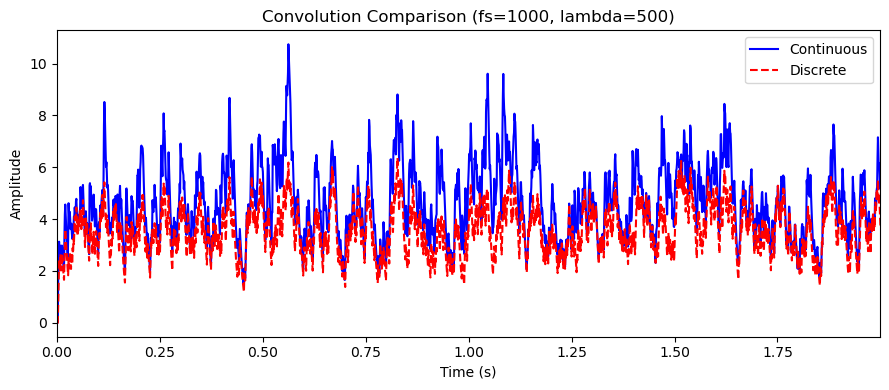

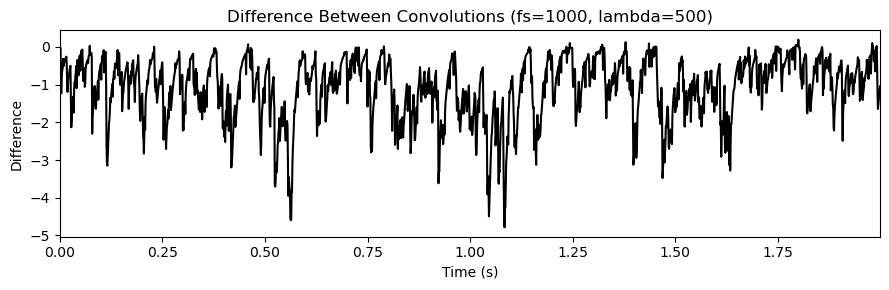

In [6]:
fs = 1000
lambda_0 = 500

results = simulate_and_compare(fs, T, lambda_0, seed)
plot_results(*results, fs=fs, lambda_0=lambda_0)


## Simulate for fs=1000 and lambda_0=500

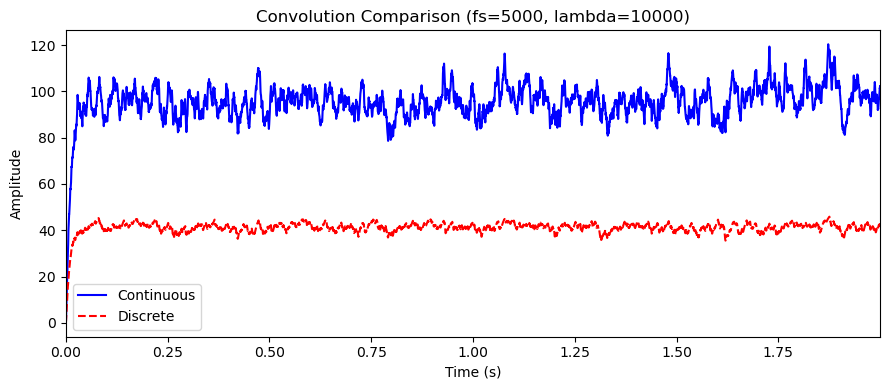

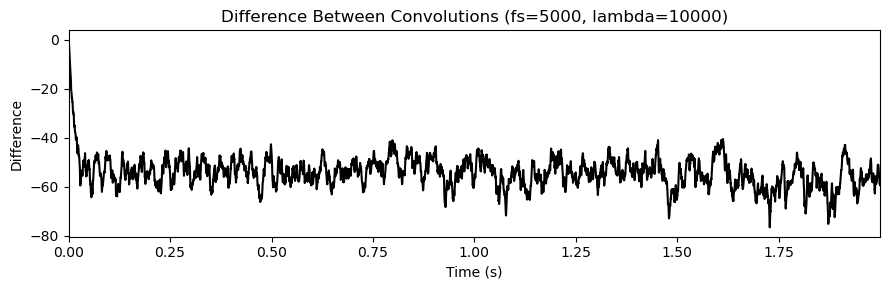

In [7]:
fs = 5000
lambda_0 = 10000

results = simulate_and_compare(fs, T, lambda_0, seed)
plot_results(*results, fs=fs, lambda_0=lambda_0)


## Trend in error

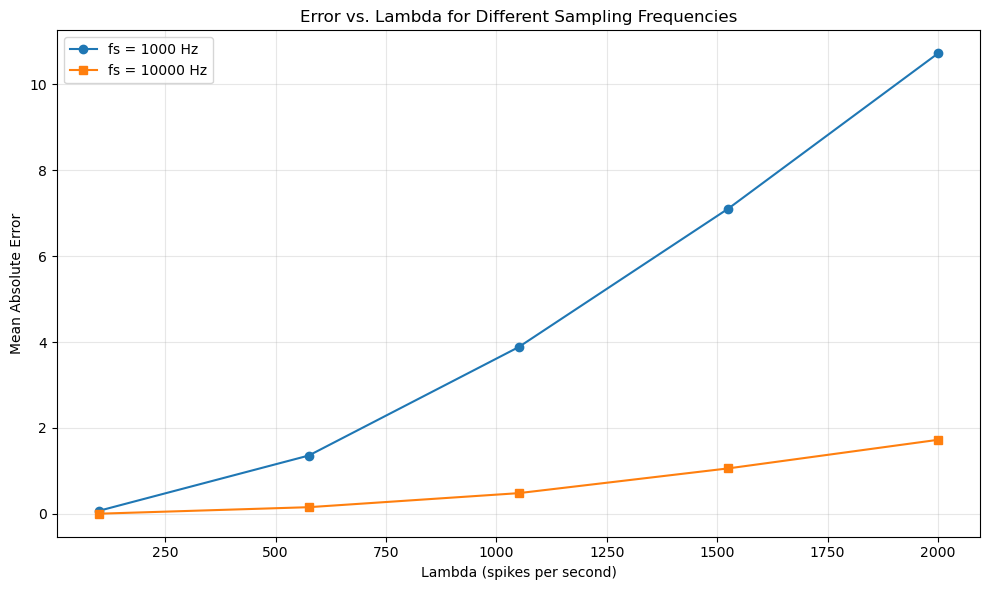

In [8]:
def simulate_error_vs_lambda(fs, T, lambda_values, seed=42):
    errors = []  # To store error values
    for lambda_0 in lambda_values:
        model_params = {"lambda_0": lambda_0}
        simulation_params = {"fs": fs, "T": T, "simulate": True, "seed": seed}
        model = Model("homogeneous_poisson", model_params, simulation_params)

        filters = {"GABA": "GABA"}
        filter_params = {}

        fpp = FilteredPointProcess(filters=filters, model=model, filter_params=filter_params)
        fpp.apply_filter_sequences(["GABA"])

        kernel = fpp.filter_instances["GABA"].kernel
        kernel_time = fpp.filter_instances["GABA"].kernel_time_axis
        spike_times = model.spikes
        time_axis = fpp.time_axis

        # Continuous convolution
        continuous_result = fpp.continuous_convolution(spike_times, kernel, kernel_time, time_axis)

        # Discrete convolution
        spike_train = np.zeros_like(time_axis)
        for st in spike_times:
            idx = int(round(st * fs))
            if idx < len(spike_train):
                spike_train[idx] = 1

        discrete_result_full = np.convolve(spike_train, kernel, mode="full")

        # Calculate the difference
        idx_end = len(time_axis)
        diff_values = discrete_result_full[:idx_end] - continuous_result
        errors.append(np.mean(np.abs(diff_values)))  # Use mean absolute error

    return errors

# Simulation parameters
T = 2
lambda_values = np.linspace(100, 2000, 5) 

fs_1000_errors = simulate_error_vs_lambda(1000, T, lambda_values)
fs_10000_errors = simulate_error_vs_lambda(10000, T, lambda_values)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, fs_1000_errors, label="fs = 1000 Hz", marker="o")
plt.plot(lambda_values, fs_10000_errors, label="fs = 10000 Hz", marker="s")
plt.xlabel("Lambda (spikes per second)")
plt.ylabel("Mean Absolute Error")
plt.title("Error vs. Lambda for Different Sampling Frequencies")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
